## Authenticate to Colab, Cloud and GEE

In [1]:
from google.colab import drive
from google.colab import files
import sys

drive.mount('/content/gdrive/', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Colab Notebooks/Classification/USA/Yolo_2/'
model_dir = base_dir + 'models/'
IMAGES_PATH = base_dir + '/' + 'Yolo_2016_16c/'

sys.path.append(base_dir) 

Mounted at /content/gdrive/


## Import Libraries

In [2]:
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
print(tf.__version__)
import folium
print(folium.__version__)

2.4.0
0.8.3


# Initialize global variables and functions

In [3]:
LABEL = 'landcover'


# landcovers = ['Rice', 'Alfalfa', 'Wheat', 'Sunflower', 'Safflower', 'Corn', 'YP', 'Tomatoes', 
#               'Grain and Hay', 'Grapes', 'Deciduous','Subtropical', 'Other Grass', 'Other Crops',
#               'Wetland', 'Fallowland', 'Buildup'];
landcovers = ["Rice", "Safflower", "Corn", "Other Field crops", "Alfalfa", "Other Pasture", "Cucurbits", "Tomatoes", 
             "Other Truck Crops", "Almonds and pistachios", "Other Deciduous", "Subtropical", "Vineyards", "Other"]              
nClasses = 16
r = 7

In [4]:
# new_labels = tf.constant([0,1,2,3,4,5,6,13,7,13,13,13,13,13,10,13,13,13,13,8,13,13,11,10,10,10,10,9,10,10,11,11,10,10,11,13,12,10,12,13,14,15,16], dtype = tf.int32,)
new_labels = tf.constant([0,4,13,3,1,2,13,6,7,8,8,8,8,8,10,3,8,8,8,13,3,8,11,10,9,9,10,12,10,10,11,11,10,10,11,8,5,10,5,8,13,13,13], dtype = tf.int32,)

new_labels

<tf.Tensor: shape=(43,), dtype=int32, numpy=
array([ 0,  4, 13,  3,  1,  2, 13,  6,  7,  8,  8,  8,  8,  8, 10,  3,  8,
        8,  8, 13,  3,  8, 11, 10,  9,  9, 10, 12, 10, 10, 11, 11, 10, 10,
       11,  8,  5, 10,  5,  8, 13, 13, 13], dtype=int32)>

In [5]:
train_path = IMAGES_PATH + 'training_yolo_2016_16c'
validation_path = IMAGES_PATH + 'validation_yolo_2016_16c'
test_path = IMAGES_PATH + 'testing_yolo_2016_16c'

train_file_prefix = 'training_yolo_2016'
validation_file_prefix = 'validation_yolo_2016'
test_file_prefix = 'testing_yolo_2016'

def getDatasetPaths(path, image_file_prefix):
  filesList = listdir(path = path)
  exportFilesList = [s for s in filesList if image_file_prefix in s]
  imageFilesList = []

  for f in exportFilesList:
    if f.endswith('.tfrecord.gz'):
      imageFilesList.append(f)
    elif f.endswith('.json'):
      jsonFile = f

  datasetPaths = [path + '/' + f for f in imageFilesList] 
  return datasetPaths

train_dataset_paths = getDatasetPaths(train_path, train_file_prefix)
validation_dataset_paths = getDatasetPaths(validation_path, validation_file_prefix)
test_dataset_paths = getDatasetPaths(test_path, test_file_prefix)


In [6]:
FEATURE_NAMES = []
bands =  ['B2', 'B3', 'B4', 'B5', 'B6','B7', 'NDVI', 'GNDVI', 'EVI', 'SAVI', 'BSI', 'NDWI', 'NDBI']
# bands =  ['NDVI', 'GNDVI', 'EVI', 'SAVI', 'BSI', 'NDWI', 'NDBI']

# bands =  ['B2', 'B3', 'B4', 'B5', 'B6','B7']

time_stamps = 9
n_features = len(bands)
for i in range(time_stamps):
  if i > 0:
    s = [b + '_' + str(i) for b in bands]
  else:
    s = bands
  FEATURE_NAMES.extend(s)
FEATURE_NAMES.append(LABEL)
# for b in bands:
#   for i in range(time_stamps):
#     if i > 0:
#       s = b + '_' + str(i)
#     else:
#       s = b
#     FEATURE_NAMES.append(s)  
  
# FEATURE_NAMES.append(LABEL)
# FEATURE_NAMES

# Data preparation and pre-processing

In [7]:
# List of fixed-length features, all of which are float32.
from pprint import pprint
import numpy as np
# z = np.zeros(91,).tolist()

columns = [
  tf.io.FixedLenSequenceFeature(shape=[r,r], dtype=tf.float32, allow_missing = True) for k in FEATURE_NAMES
]
# Dictionary with names as keys, features as values.
from collections import OrderedDict 

# featuresDict = dict(zip(FEATURE_NAMES, columns))
featuresDict = OrderedDict(zip(FEATURE_NAMES, columns))

# pprint(featuresDict)

In [8]:
# Create a dataset from the TFRecord file in Cloud Storage.

depth = len(FEATURE_NAMES)-1
def toTuple(data, label):
  spectral = []
  for i in range(0, depth, n_features):
    band_values = []
    for f in FEATURE_NAMES[i:i+n_features]:
      if f.startswith('B'):
        band_values.append((tf.reshape(data[f],(r,r))[3,3])/10000)
      else:
        band_values.append(tf.reshape(data[f],(r,r))[3,3])
    spectral.append(band_values)
  
  # spectral = tf.transpose(spectral, [2,3,0,1])
  label = tf.gather(new_labels, label)

  return spectral, label

# def toTuple(data, label):
  
#   band_values = []
#   for f in FEATURE_NAMES[:-1]:
#     a = tf.reshape(data[f], (7,7,1))[3,3]
#     band_values.append(a)

#   spectral = band_values
#   label = tf.gather(new_labels, label)

#   return spectral, label

def parse_tfrecord(example_proto):
  parsed_features = tf.io.parse_single_example(example_proto, featuresDict)
  labels = parsed_features.pop(LABEL)
  labels = tf.cast(labels, tf.int32)
  label = tf.math.argmax(tf.math.bincount(labels))
  return parsed_features, label

def getDataset(datasetPaths):
  dataset = tf.data.TFRecordDataset(datasetPaths, compression_type='GZIP')
  parsedDataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  inputDataset = parsedDataset.map(toTuple)
  return inputDataset

trainDataset = getDataset(train_dataset_paths)
validationDataset = getDataset(validation_dataset_paths)
testDataset = getDataset(test_dataset_paths)
alltestDataset = validationDataset.concatenate(testDataset)

In [9]:
for data, target in testDataset.take(5):
  print(data.shape)
  # print(data)
  print(target)

(9, 13)
tf.Tensor(0, shape=(), dtype=int32)
(9, 13)
tf.Tensor(7, shape=(), dtype=int32)
(9, 13)
tf.Tensor(12, shape=(), dtype=int32)
(9, 13)
tf.Tensor(13, shape=(), dtype=int32)
(9, 13)
tf.Tensor(0, shape=(), dtype=int32)


# 1D CNN

In [ ]:
pad = 'same'
l2 = 0
l1 = 0

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (time_stamps,n_features),),
    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, activation = 'relu', padding = pad, kernel_regularizer=tf.keras.regularizers.L1L2(l2 = l2, l1 = l1)),
    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, activation = 'relu', padding = pad, kernel_regularizer=tf.keras.regularizers.L1L2(l2 = l2, l1 = l1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, activation = 'relu', padding = pad, kernel_regularizer=tf.keras.regularizers.L1L2(l2 = l2, l1 = l1)),
    tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, activation = 'relu', padding = pad, kernel_regularizer=tf.keras.regularizers.L1L2(l2 = l2, l1 = l1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation = 'relu',  kernel_regularizer=tf.keras.regularizers.L1L2(l2 = l2, l1 = l1)),
    tf.keras.layers.Dense(14, activation = 'softmax')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_28 (Batc (None, 9, 13)             52        
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 9, 64)             2560      
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 9, 64)             12352     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 4, 64)             256       
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 4, 128)            24704     
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 4, 128)           

In [14]:
input =  tf.keras.layers.Input(shape = (time_stamps,n_features))
x = tf.keras.layers.BatchNormalization()(input)
x =  tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'valid')(x)
x1 = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x2 = tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'valid')(x)
x3 = tf.keras.layers.Conv1D(filters = 64, kernel_size = 5, activation = 'relu', padding = 'valid')(x)
x = tf.keras.layers.concatenate([x1, x2, x3], axis = 1)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'valid')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x =  tf.keras.layers.Conv1D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'valid')(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dense(14, activation = 'softmax')(x)
model = tf.keras.Model(input, x)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 9, 13)]      0                                            
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 9, 13)        52          input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 7, 64)        2560        batch_normalization_2[0][0]      
__________________________________________________________________________________________________
max_pooling1d_2 (MaxPooling1D)  (None, 3, 64)        0           conv1d_10[0][0]                  
____________________________________________________________________________________________

In [15]:
batch_size = 128
num_epochs = 60

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=2, min_lr=1e-10, min_delta=0.01, verbose = 1)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    model_dir + '/model3_conv1d_2016_9x13_13c', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
    options=None
)

optim = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy']) 

history = model.fit(trainDataset.batch(batch_size), 
                    batch_size=batch_size, 
                    epochs=num_epochs, verbose=1,
                    validation_data = alltestDataset.batch(batch_size),
                    callbacks = [reduce_lr, 
                                 model_checkpoint_callback
                                 ]
)

Epoch 1/60
1217/1217 [==============================] - 385s 316ms/step - loss: 0.8862 - accuracy: 0.7332 - val_loss: 0.5108 - val_accuracy: 0.8588
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/Classification/USA/Yolo_2/models/model3_conv1d_2016_9x13_13c/assets
Epoch 2/60
1217/1217 [==============================] - 149s 123ms/step - loss: 0.4576 - accuracy: 0.8687 - val_loss: 0.5042 - val_accuracy: 0.8687
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/Classification/USA/Yolo_2/models/model3_conv1d_2016_9x13_13c/assets
Epoch 3/60
1217/1217 [==============================] - 148s 122ms/step - loss: 0.3908 - accuracy: 0.8880 - val_loss: 0.5287 - val_accuracy: 0.8620

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
Epoch 4/60
1217/1217 [==============================] - 147s 121ms/step - loss: 0.3477 - accuracy: 0.9018 - val_loss: 0.5342 - val_accuracy: 0.8633
Epoch 5/60
1217/1217 [=================

KeyboardInterrupt: ignored

In [16]:
# model = tf.keras.models.load_model(model_dir + '/model3_conv3d_2016_7x7x9x13')
# model = tf.keras.models.load_model(model_dir + '/model4_conv3d_2016_7x7x9x6')
model = tf.keras.models.load_model(model_dir + '/model3_conv1d_2016_9x13_13c')


In [17]:
model.evaluate(alltestDataset.batch(1000))

128/128 [==============================] - 60s 461ms/step - loss: 0.5535 - accuracy: 0.8794


[0.5535498857498169, 0.8793640732765198]

## Analysis

[[13657     7    22     9    13    13    30   182     2    48    39     4
     22   333]
 [   12  2860    37    46    94     1     5    16    12     6     3     2
      9   226]
 [   37    12  1693   271    16    26   197   161    18     3     4     0
     18   185]
 [   72   266   114  5994    21     0   196   457   107    19    24     1
     20   333]
 [    4    61     7    56  9149   140    12    61    13    50   109     1
     39   320]
 [    4     0     0     6   285  3788     1     2   112    14    42     3
     15   501]
 [   17     8    18    40     8     0  1632    92    66     4    29     0
      5   159]
 [   13     5    82    78    13     1   101  9381    25    19    15     1
     20   252]
 [   28    13    50    36    22     6   230   213   733    43    32     1
     26   449]
 [    0    13     2    13    49     3     1    21    11  8761   107    78
    185  1310]
 [    2     0     1     8    71     6     3    11    23    80  5364    13
     86   424]
 [    0     0     0  

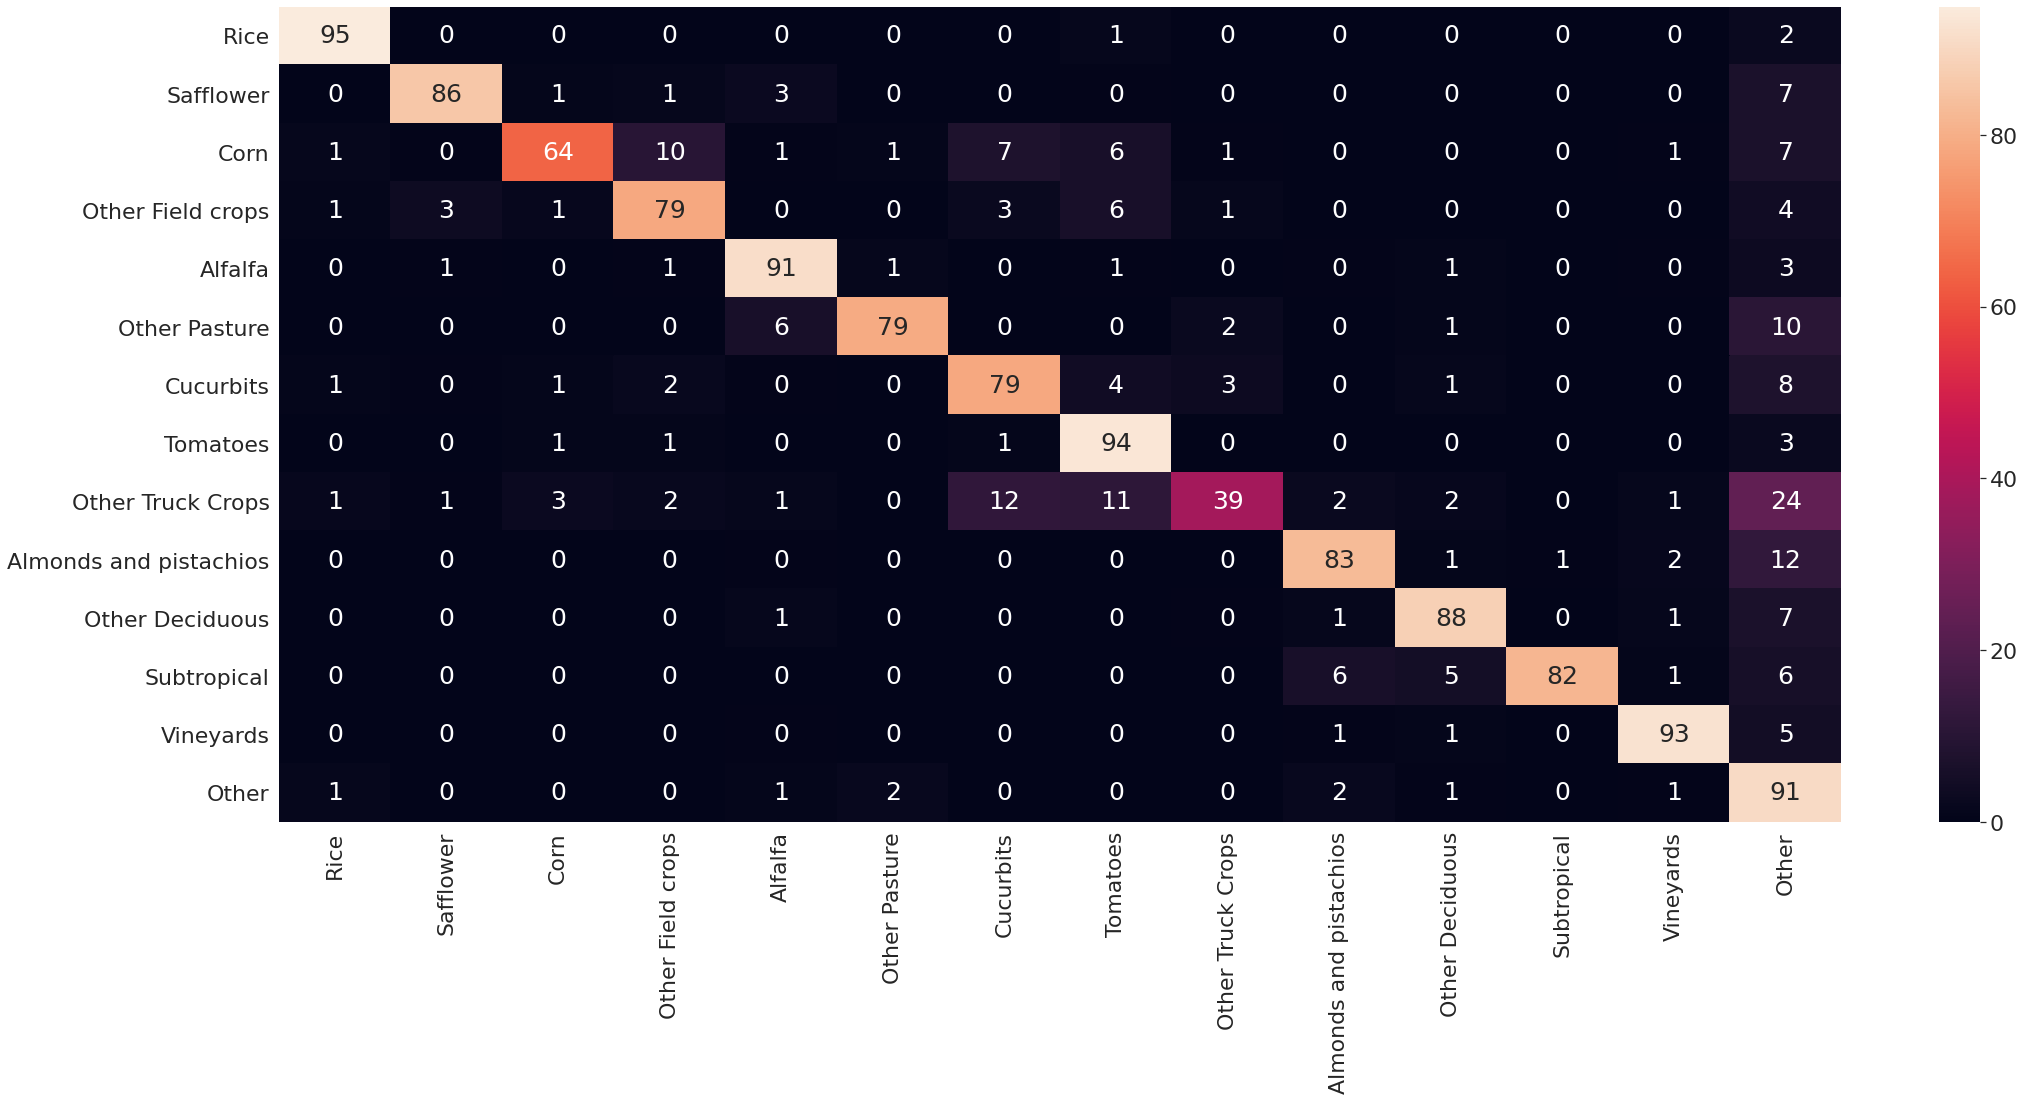

In [18]:
y_pred = np.argmax(model.predict(alltestDataset.batch(1000)),axis = 1)
y_true = tf.concat([y for x, y in alltestDataset], axis=0)

cf = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()

print(cf)
s = np.sum(cf, axis = 1)

# cf1 = pd.DataFrame(cf/(s.reshape(nClasses-1, 1)), columns=landcovers[:-1], index = landcovers[:-1])
cf1 = pd.DataFrame((cf/(s.reshape(14, 1)))*100, columns=landcovers, index = landcovers)

plt.figure(figsize = (35,15))
sns.set(font_scale=2) 
sns.heatmap(cf1, annot=True, annot_kws={"size": 25},fmt = '.0f');

In [20]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average = 'weighted')

0.8779666058642979